This notebook is maintained as a part of CODETROPHS Internship task. It builds a model which assigns a flair to a reddit post. It contains the following sections - 
1. Data Collection - Using web scraping of reddit.com.
2. Exploratory Data Analysis - Extracting useful information from the collected data.
3. Build a Flare Detector - Building various models using Natural Language Processing (NLP) and selecting the best among them.


## Data Collection

In [1]:
!pip install -q praw

     |████████████████████████████████| 153kB 11.4MB/s 
     |████████████████████████████████| 204kB 18.8MB/s 


In [2]:
# Web Scraping using PRAW - Python Reddit API Wrapper

import praw
reddit = praw.Reddit(client_id = "fetMsk0M5GBU3Q", client_secret = "V8rQ_GfA6iqPcKrRRY6suL8pA5v36Q", user_agent = "my user agent", 
                     username = "urvashiramdasani", password = "Thunder_code18")

In [3]:
# Get the post names and flair for each post and store them

title = []
flair = []
subreddit = reddit.subreddit('india')
for sub in subreddit.top(limit = None):
  title.append(sub.title)
  flair.append(sub.link_flair_text)
print(title)
print(flair)

['Will donate thrice the number of upvotes (amount in Rs.) i get for this thread in next 24 hours', 'Fuck all Religion', 'Indian reply to NYtimes cartoon on Paris climate accord by Satish Acharya.', 'The essence of the Indian soap opera, distilled into one GIF.', 'Lamborghini blocked by buffaloes in India', 'As a Brazilian, I just want to say that you guys are in another level!', 'iPhone 12 pricing in India', 'This looks legit..', 'China get out. Boycott China. .. Sponsored by Vivo.', 'I’m a westerner who has worked hard learning your amazing food and culture. Today I presented my first thali. Jai Hindi', 'Boycott China.', "Today's The Hindu", 'German exchange Student at IIT Madras is being sent back home by the Indian immigration department because he joined the protest.', "India had 90,000 new COVID cases in a SINGLE DAY. The media is talking about Rhea Chakraborty to distract you. Don't get sucked in.", 'WhiteHatJr filed a 20 CRORE defamation case against me, Pradeep Poonia.', 'Trag

In [4]:
len(title) == len(flair) # Check if the above procedure is correct

True

In [5]:
import pandas as pd
df = pd.DataFrame(list(zip(title, flair)), columns = ['Title', 'Flair'])
df

,Title,Flair
0,Will donate thrice the number of upvotes (amou...,[R]eddiquette
1,Fuck all Religion,Politics
2,Indian reply to NYtimes cartoon on Paris clima...,/r/all
3,"The essence of the Indian soap opera, distille...",r/all
4,Lamborghini blocked by buffaloes in India,Non-Political
...,...,...
974,Azim Premji among the highest private donors f...,Coronavirus
975,"Dog found in Jaipur (OnePlus5, 1306x979)",Photography
976,A friend of prepared meals and distributed it ...,Unverified
977,Happy 99th birthday Satyajit Ray!,Non-Political


## Exploratory Data Analysis (EDA)

In [6]:
# In this, I have grouped similar name topics, like Politics and Politics [Megathread]

df = df.replace(to_replace = "Politics [Megathread]", value = "Politics")
df = df.replace(to_replace = "Politics -- Source in comments", value = "Politics")
df = df.replace(to_replace = "OC", value = "Art/Photo (OC)")
df = df.replace(to_replace = "Policy/Economy", value = "Policy & Economy")
df = df.replace(to_replace = "Policy/Economy -2017 Article", value = "Policy & Economy")
df = df.replace(to_replace = "r/all", value = "/r/all")
df = df.replace(to_replace = "Join r/IndiaMeme", value = "r/indiameme")

In [7]:
df.groupby('Flair').count()['Title']

Flair
/r/all                             4
Art/Photo (OC)                    15
AskIndia                           9
Business/Finance                  28
CAA-NRC                            4
CAA-NRC-NPR                        1
Casual AMA                         1
Coronavirus                       55
Demonetization                     1
Food                              34
History                            1
Misleading Headline                1
Moderated                          1
Non-Political                    352
Official Sadness Thread            1
Original Comics                    1
Photography                       44
Policy & Economy                  21
Policy/Economy -2017 Article       1
Politics                         329
Scheduled                          1
Science/Technology                13
Sports                            23
TW for South Indian People         1
They Knew                          1
Totally real                       1
Unverified                      

In [8]:
df.to_csv('Reddit_Flair_Detection_Data.csv') # Saving data

## Building a Flare Detector
Below, I have used Natural Language Processing (NLP) to process the titles of the post and predicted its flare. I have used a variety of algorithms for correct classificiation. 

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
dataset = pd.read_csv("Reddit_Flair_Detection_Data.csv")
dataset.groupby('Flair').count()['Title']

Flair
/r/all                             4
Art/Photo (OC)                    15
AskIndia                           9
Business/Finance                  28
CAA-NRC                            4
CAA-NRC-NPR                        1
Casual AMA                         1
Coronavirus                       55
Demonetization                     1
Food                              34
History                            1
Misleading Headline                1
Moderated                          1
Non-Political                    352
Official Sadness Thread            1
Original Comics                    1
Photography                       44
Policy & Economy                  21
Policy/Economy -2017 Article       1
Politics                         329
Scheduled                          1
Science/Technology                13
Sports                            23
TW for South Indian People         1
They Knew                          1
Totally real                       1
Unverified                      

In [11]:
# Building corpus - This step would remove all the english stopwords such as and, the, etc. since they would not contribute
# to the meaning of the title. Basic processing such as lower, split have been performed. 

import concurrent.futures
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for i in tqdm(range(0, dataset.shape[0])):
        book = re.sub('[^a-zA-Z]', ' ', dataset['Title'][i]) # Filter non alphabetical chars
        book = book.lower() # Convert to lowercase
        book = book.split() # Split on spaces
        ps = PorterStemmer() # Stem
        book = [ps.stem(word) for word in book if not word in set(stopwords.words('english'))]
        book = ' '.join(book) 
        corpus.append(book)

100%|██████████| 979/979 [00:01<00:00, 526.82it/s]


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit(corpus)
joblib.dump(X, "vectorizer2.joblib")

['vectorizer2.joblib']

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = dataset['Flair'].values # Get target categories
y = label_encoder.fit_transform(y) # Encode category labels to integers

In [14]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)
print(X_train.shape, X_test.shape)

(969, 3006) (10, 3006)


In [15]:
name_map = pd.DataFrame.from_dict(dict(zip(label_encoder.classes_, 
                                           label_encoder.transform(label_encoder.classes_))), 
                                  orient='index')
print(name_map)

                                0
/r/all                          0
Art/Photo (OC)                  1
AskIndia                        2
Business/Finance                3
CAA-NRC                         4
CAA-NRC-NPR                     5
Casual AMA                      6
Coronavirus                     7
Demonetization                  8
Food                            9
History                        10
Misleading Headline            11
Moderated                      12
Non-Political                  13
Official Sadness Thread        14
Original Comics                15
Photography                    16
Policy & Economy               17
Policy/Economy -2017 Article   18
Politics                       19
Scheduled                      20
Science/Technology             21
Sports                         22
TW for South Indian People     23
They Knew                      24
Totally real                   25
Unverified                     26
Zoke Tyme                      27
[R]eddiquette 

In [16]:
## This import is useful later 
from sklearn.metrics import classification_report, accuracy_score

In [17]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='sag',max_iter=200,random_state=450,
                                             n_jobs=4, verbose=True)
lr.fit(X_train, y_train)
        
# Evaluate on train and test set
print("Train set score:", lr.score(X_train, y_train))
print("Test set score:", lr.score(X_test, y_test))

# Generate classification report
y_pred = lr.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.2s finished


convergence after 57 epochs took 0 seconds
Train set score: 0.6914344685242518
Test set score: 0.6
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
          13       0.43      1.00      0.60         3
          17       0.00      0.00      0.00         1
          19       1.00      0.60      0.75         5

    accuracy                           0.60        10
   macro avg       0.36      0.40      0.34        10
weighted avg       0.63      0.60      0.55        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=200, criterion='entropy', 
                                    warm_start=True, n_jobs=4, verbose=True)
rf.fit(X_train, y_train)

# Evaluate on train and test set
print("Train set score:", rf.score(X_train, y_train))
print("Test set score:", rf.score(X_test, y_test))

# Generate classification report
y_pred = rf.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Train set score: 0.9917440660474717
Test set score: 0.6


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
          13       0.50      0.67      0.57         3
          17       0.00      0.00      0.00         1
          19       0.67      0.80      0.73         5

    accuracy                           0.60        10
   macro avg       0.29      0.37      0.32        10
weighted avg       0.48      0.60      0.54        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score :  0.6
Confusion Matrix : 
[[0 1 0 0]
 [0 2 0 1]
 [0 0 0 1]
 [0 1 0 4]]


['vec.joblib']

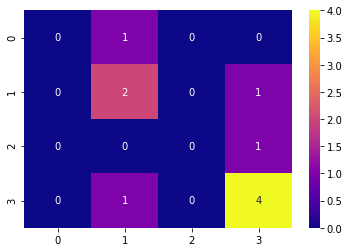

In [27]:
# We will use Random Forests since it has the maximum accuracy.
# We can see below that the accuracy score is 60%. 
# Accuracy and other measures
from sklearn import metrics
import seaborn as sns
import joblib

print('Accuracy Score : ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
print('Confusion Matrix : ')
cm = metrics.confusion_matrix(y_true = y_test, y_pred = y_pred)
print(cm)
sns.heatmap(cm, annot = True, cmap = 'plasma')
joblib.dump(rf, "vec.joblib")

In [19]:
# XGBoost

from xgboost import XGBClassifier
import joblib

xgb = XGBClassifier(max_depth=50, n_estimators=100, booster='gbtree',
                            objective='reg:logistic', gamma=0.1, rate_drop=0.3, 
                            nthread=4, verbosity=0);
xgb.fit(X_train, y_train)

# Evaluate and dump
print("Train set score:", xgb.score(X_train, y_train))
print("Test set score:", xgb.score(X_test, y_test))
# Generate classification report
y_pred = xgb.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

# Save the model
joblib.dump(name_map, './name_map.joblib', compress = True)
joblib.dump(xgb, './gradient_boost.joblib', compress = True)

Train set score: 0.8658410732714138
Test set score: 0.4
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
          13       0.50      0.33      0.40         3
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          19       0.60      0.60      0.60         5
          28       0.00      0.00      0.00         0

    accuracy                           0.40        10
   macro avg       0.16      0.13      0.14        10
weighted avg       0.45      0.40      0.42        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['./gradient_boost.joblib']

In [20]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
import pickle
nb = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)
nb.fit(X_train, y_train)
    
# Evaluate and dump
print("Train set score:", nb.score(X_train, y_train))
print("Test set score:", nb.score(X_test, y_test))
model = open("model.pkl", "ab")
pickle.dump(nb, model)

# Generate classification report
y_pred = nb.predict(X_test)
print(classification_report(y_test.astype(int), y_pred))

Train set score: 0.932920536635707
Test set score: 0.6
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
          13       0.60      1.00      0.75         3
          17       0.00      0.00      0.00         1
          19       0.75      0.60      0.67         5

    accuracy                           0.60        10
   macro avg       0.34      0.40      0.35        10
weighted avg       0.55      0.60      0.56        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Advantages of the developed model - 
1. It will take only the title of the post to make classification.

Disadvantages - 
1. It does not analyze the image and the body of the post. 